In [26]:
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier

import numpy as np
import matplotlib.pyplot as plt

### Baseline Models and Voting

In [27]:
# get the dataset
def get_dataset():
    X, y = make_classification(n_samples=5000, n_features=20, n_informative=10, n_redundant=10, random_state=1)
    return X, y

In [28]:
# summarize the dataset
print(X.shape, y.shape)

(5000, 20) (5000,)


In [29]:
# define dataset
X, y = get_dataset()

In [30]:
# get a list of models to evaluate
def get_models():
    models = list()
    models.append(('lr', LogisticRegression()))
    models.append(('knn', KNeighborsClassifier()))
    models.append(('tree', DecisionTreeClassifier()))
    models.append(('nb', GaussianNB()))
    models.append(('svm', SVC(probability=True)))
    return models

In [31]:
# get the models to evaluate
models = get_models()

In [32]:
# evaluate the models and store results
results, names = list(), list()
for name, model in models:
    # evaluate model
    scores = evaluate_model(model, X, y)
    # store results
    results.append(scores)
    names.append(name)
    # summarize result
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))

>lr 0.856 (0.014)
>knn 0.953 (0.008)
>tree 0.867 (0.014)
>nb 0.847 (0.021)
>svm 0.953 (0.010)


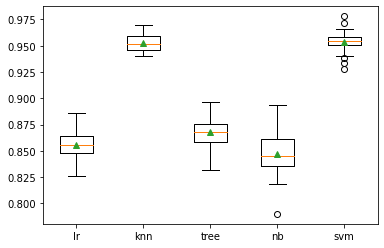

In [33]:
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

In [34]:
# create the ensemble
ensemble = VotingClassifier(estimators=models, voting='soft')

In [35]:
# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

In [36]:
# evaluate the ensemble
scores = cross_val_score(ensemble, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

In [37]:
# summarize the result
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Mean Accuracy: 0.928 (0.013)


### Ensemble Pruning Example

In [38]:
# evaluate a list of models
def evaluate_ensemble(models, X, y):
    # check for no models
    if len(models) == 0:
        return 0.0
    # create the ensemble
    ensemble = VotingClassifier(estimators=models, voting='soft')
    # define the evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # evaluate the ensemble
    scores = cross_val_score(ensemble, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    # return mean score
    return np.mean(scores)

In [39]:
# perform a single round of pruning the ensemble
def prune_round(models_in, X, y):
    # establish a baseline
    baseline = evaluate_ensemble(models_in, X, y)
    best_score, removed = baseline, None
    # enumerate removing each candidate and see if we can improve performance
    for m in models_in:
        # copy the list of chosen models
        dup = models_in.copy()
        # remove this model
        dup.remove(m)
        # evaluate new ensemble
        result = evaluate_ensemble(dup, X, y)
        # check for new best
        if result > best_score:
            # store the new best
            best_score, removed = result, m
    return best_score, removed

In [40]:
# prune an ensemble from scratch
def prune_ensemble(models, X, y):
    best_score = 0.0
    # prune ensemble until no further improvement
    while True:
        # remove one model to the ensemble
        score, removed = prune_round(models, X, y)
        # check for no improvement
        if removed is None:
            print('>no further improvement')
            break
        # keep track of best score
        best_score = score
        # remove model from the list
        models.remove(removed)
        # report results along the way
        print('>%.3f (removed: %s)' % (score, removed[0]))
    return best_score, models

In [41]:
# prune the ensemble
score, model_list = prune_ensemble(models, X, y)
names = ','.join([n for n,_ in model_list])
print('Models: %s' % names)
print('Final Mean Accuracy: %.3f' % score)

>0.940 (removed: nb)
>0.948 (removed: tree)
>0.956 (removed: lr)
>no further improvement
Models: knn,svm
Final Mean Accuracy: 0.956


### Ensemble Growing Example

In [42]:
# perform a single round of growing the ensemble
def grow_round(models_in, models_candidate, X, y):
    # establish a baseline
    baseline = evaluate_ensemble(models_in, X, y)
    best_score, addition = baseline, None
    # enumerate adding each candidate and see if we can improve performance
    for m in models_candidate:
        # copy the list of chosen models
        dup = models_in.copy()
        # add the candidate
        dup.append(m)
        # evaluate new ensemble
        result = evaluate_ensemble(dup, X, y)
        # check for new best
        if result > best_score:
            # store the new best
            best_score, addition = result, m
    return best_score, addition

In [43]:
# grow an ensemble from scratch
def grow_ensemble(models, X, y):
    best_score, best_list = 0.0, list()
    # grow ensemble until no further improvement
    while True:
        # add one model to the ensemble
        score, addition = grow_round(best_list, models, X, y)
        # check for no improvement
        if addition is None:
            print('>no further improvement')
            break
        # keep track of best score
        best_score = score
        # remove new model from the list of candidates
        models.remove(addition)
        # add new model to the list of models in the ensemble
        best_list.append(addition)
        # report results along the way
        names = ','.join([n for n,_ in best_list])
        print('>%.3f (%s)' % (score, names))
    return best_score, best_list

In [44]:
# grow the ensemble
score, model_list = grow_ensemble(models, X, y)
names = ','.join([n for n,_ in model_list])
print('Models: %s' % names)
print('Final Mean Accuracy: %.3f' % score)

>0.953 (svm)
>0.956 (svm,knn)
>no further improvement
Models: svm,knn
Final Mean Accuracy: 0.956
